In [1]:
from gerrychain.random import random

SEED = 0
while (SEED % 2 == 0):
    SEED = random.randrange(1000000001,9999999999)
#SEED = 7473378879
random.seed(SEED)
print(SEED)


import matplotlib.pyplot as plt
# from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
#                         proposals, updaters, constraints, accept, Election, tree)
from gerrychain import (GeographicPartition, Partition, Graph,
                        updaters, Election, tree)
#from gerrychain.proposals import recom
#from gerrychain.tree import (recursive_tree_part, bipartition_tree)
from functools import partial
import pandas
import geopandas as gp
import time
import csv
import os
import numpy as np



# FUNCTIONS --------------------------------------------------------------------------------------------

# Input: Gerrychain partition object
# Output: number of majority-minority districts (<50% non-Hispanic white)
def calculate_MM_districts_basic(my_partition):
    
    plur_W = 0
    
    for district in my_partition['nhwhitepop']:
    
        fraction_W = my_partition['nhwhitepop'][district]/my_partition['population'][district]

        if fraction_W < 0.5:
            plur_W += 1
            
    return plur_W


# Input: Gerrychain partition object
# Output: number of majority-minority districts that are plurality Black, Lat/Hisp, and nh-white
def calculate_MM_districts(my_partition):
    
    plur_B = 0
    plur_L = 0
    plur_W = 0
    
    for district in my_partition['nhwhitepop']:
    
        fraction_W = my_partition['nhwhitepop'][district]/my_partition['population'][district]
        fraction_B = my_partition['blackpop'][district]/my_partition['population'][district]
        fraction_L = my_partition['latpop'][district]/my_partition['population'][district]

        if fraction_W < 0.5:
            if fraction_B > max(fraction_W,fraction_L):
                plur_B += 1
            elif fraction_L > max(fraction_W,fraction_B):
                plur_L += 1
            else:
                plur_W += 1
            
    return plur_B,plur_L,plur_W


# Input: Gerrychain partition object, margin of victory (in (0,1)) that defines a competitive district
# Output: number of competitive districts (within 'margin' of victory) in that partition
def calculate_Cmpttv_districts(my_partition, margin):
    
    count_cmpttv = 0
    
    for dem_percent in my_partition['AVG'].percents('Dem'):
        if abs(dem_percent-(1-dem_percent)) <= margin:
            count_cmpttv += 1
            
    return count_cmpttv


# Input: Gerrychain partition object and two-district tuple
# Output: number of districts (out of the two) that are wholly contained within one county
def num_wholly_contained(my_partition, two_dist):
    
    count_wholly_contained = 0
    
    # Count number of counties for first district
    counties = []
    for n in list(my_partition.assignment.parts[two_dist[0]]):
        counties.append(graph.nodes[n]['GEOID20'][0:5])
    if len(set(counties)) == 1:
        count_wholly_contained += 1
        
    # Count number of counties for second district
    counties = []
    for n in list(my_partition.assignment.parts[two_dist[1]]):
        counties.append(graph.nodes[n]['GEOID20'][0:5])
    if len(set(counties)) == 1:
        count_wholly_contained += 1
        
    
    return count_wholly_contained


# Calculate Shifted Efficiency Gap (see 'Competitiveness' requirement in MO constitution 2020)
# Input: for a given plan, the fraction of dem voters in each district
#        and total number of dem/rep voters in each district
# Output: Shifted Efficiency Gap value (max absolute EG value when vote-shares
#         are shifted 0-5% uniformly in either party's favor)
def calculate_SEG(FD,TV_dem,TV_rep):
    
    FD_list = [fd for fd in FD]
    TV = [TV_dem[i]+TV_rep[i] for i in range(0,len(TV_dem))]
    
    # Shifted Efficiency Gap objective function (MO)
    percentShiftsNeg = [-0.05,-0.04,-0.03,-0.02,-0.01,0.0]
    percentShiftsPos = [0.01,0.02,0.03,0.04,0.05]
    allVotes = np.sum(TV)
    EG_shift = []

    for s in percentShiftsNeg:
        fracDem_shift = [max(fd+s,0.0) for fd in FD_list]
        numDem_shift = []
        numRep_shift = []
        for i in range(0,len(TV)):
            numDem_shift.append(fracDem_shift[i]*TV[i])
            numRep_shift.append((1-fracDem_shift[i])*TV[i])
        
        wasted_shift_dem = []
        wasted_shift_rep = []
        for i in range(0,len(numDem_shift)):
            if numDem_shift[i] >= numRep_shift[i]:
                wasted_shift_dem.append(numDem_shift[i] - 0.5*(numDem_shift[i]+numRep_shift[i]))
                wasted_shift_rep.append(numRep_shift[i])
                #wasted_shift.append(.5*(numDem_shift[i]-3*numRep_shift[i]))
            else:
                wasted_shift_rep.append(numRep_shift[i] - 0.5*(numDem_shift[i]+numRep_shift[i]))
                wasted_shift_dem.append(numDem_shift[i])
                #wasted_shift.append(.5*(3*numDem_shift[i]-numRep_shift[i]))
                
        #EG_shift.append(round(abs(sum(wasted_shift))/allVotes,10))
        wasted_shift = np.sum(wasted_shift_rep) - np.sum(wasted_shift_dem)
        EG_shift.append(np.round(wasted_shift/allVotes,10))
        
        
    for s in percentShiftsPos:
        fracDem_shift = [min(fd+s,1.0) for fd in FD_list]
        numDem_shift = []
        numRep_shift = []
        for i in range(0,len(TV)):
            numDem_shift.append(fracDem_shift[i]*TV[i])
            numRep_shift.append((1-fracDem_shift[i])*TV[i])
            
        wasted_shift_dem = []
        wasted_shift_rep = []
        for i in range(0,len(numDem_shift)):
            if numDem_shift[i] >= numRep_shift[i]:
                wasted_shift_dem.append(numDem_shift[i] - 0.5*(numDem_shift[i]+numRep_shift[i]))
                wasted_shift_rep.append(numRep_shift[i])
                #wasted_shift.append(.5*(numDem_shift[i]-3*numRep_shift[i]))
            else:
                wasted_shift_rep.append(numRep_shift[i] - 0.5*(numDem_shift[i]+numRep_shift[i]))
                wasted_shift_dem.append(numDem_shift[i])
                #wasted_shift.append(.5*(3*numDem_shift[i]-numRep_shift[i]))
                
        #EG_shift.append(round(abs(sum(wasted_shift))/allVotes,10))
        wasted_shift = np.sum(wasted_shift_rep) - np.sum(wasted_shift_dem)
        EG_shift.append(np.round(wasted_shift/allVotes,10))
        

#     print('-----')
#     for val in EG_shift:
#         print(val)

    #return max(EG_shift)
    #return EG_shift

    abs_seg = [abs(eg_val) for eg_val in EG_shift]
    max_abs_val = max(abs_seg)
    
    return max_abs_val


# Modified from GerryChain package:
# https://github.com/mggg/GerryChain/blob/main/gerrychain/tree.py
# Returns random balance cut
def bipartition_tree(
    graph,
    pop_col,
    pop_target,
    epsilon,
    node_repeats=1,
    spanning_tree=None,
    spanning_tree_fn=tree.random_spanning_tree,
    balance_edge_fn=tree.find_balanced_edge_cuts_memoization,
    choice = random.choice
):
    
    populations = {node: graph.nodes[node][pop_col] for node in graph}

    possible_cuts = []
    
    if spanning_tree is None:
        spanning_tree = spanning_tree_fn(graph)
        
    restarts = 0
    attempts = 0
    #while len(possible_cuts) == 0:
    while attempts < 250:
        if restarts == node_repeats:
            spanning_tree = spanning_tree_fn(graph)
            restarts = 0
        h = tree.PopulatedGraph(spanning_tree, populations, pop_target, epsilon)
        possible_cuts = balance_edge_fn(h, choice=choice)
        
        if len(possible_cuts) != 0:
            return choice(possible_cuts).subset
        
        restarts += 1
        attempts += 1
        #print('Attempts: ',attempts)

    return None



# Modified from GerryChain package:
# https://github.com/mggg/GerryChain/blob/main/gerrychain/tree.py
# Returns all possible cuts
def bipartition_tree_greedy(
    graph,
    pop_col,
    pop_target,
    epsilon,
    node_repeats=1,
    spanning_tree=None,
    spanning_tree_fn=tree.random_spanning_tree,
    balance_edge_fn=tree.find_balanced_edge_cuts_memoization,
    choice = random.choice
):
    
    populations = {node: graph.nodes[node][pop_col] for node in graph}

    possible_cuts = []
    if spanning_tree is None:
        spanning_tree = spanning_tree_fn(graph)
    restarts = 0
    attempts = 0
    #while len(possible_cuts) == 0:
    while attempts < 250:
        if restarts == node_repeats:
            spanning_tree = spanning_tree_fn(graph)
            restarts = 0
        h = tree.PopulatedGraph(spanning_tree, populations, pop_target, epsilon)
        possible_cuts = balance_edge_fn(h, choice=choice)
        
        if len(possible_cuts) != 0:
            return [c.subset for c in possible_cuts]
        
        restarts += 1
        attempts += 1

    return None



# Modified from recursive_tree_part GerryChain package:
# https://github.com/mggg/GerryChain/blob/main/gerrychain/tree.py
# We only ever partition into two parts
def tree_part_flips(
    graph, parts, pop_target, pop_col, epsilon, node_repeats=1, method=bipartition_tree
):

    #flips = {}
    remaining_nodes = set(graph.nodes)   
    
    # Returns subset of nodes for new district
    nodes_subset = method(
        graph.subgraph(remaining_nodes),
        pop_col=pop_col,
        pop_target=pop_target,
        epsilon=epsilon,
        node_repeats=node_repeats,
    )

    if nodes_subset is None:
        return None

    
    flips = {}
    for node in nodes_subset:
        flips[node] = parts[0]

    remaining_nodes -= nodes_subset

    # All of the remaining nodes go in the last part
    for node in remaining_nodes:
        flips[node] = parts[-1]

        
    return flips




# Modified from recursive_tree_part GerryChain package:
# https://github.com/mggg/GerryChain/blob/main/gerrychain/tree.py
# We only ever partition into two parts
def tree_part_flips_greedy(
    graph, parts, pop_target, pop_col, epsilon, node_repeats=1, method=bipartition_tree_greedy
):

    remaining_nodes = set(graph.nodes)       
    
    # Modified greedy method returns list of node subsets
    nodes_list = method(
        graph.subgraph(remaining_nodes),
        pop_col=pop_col,
        pop_target=pop_target,
        epsilon=epsilon,
        node_repeats=node_repeats,
    )

    if nodes_list is None:
        return None

    flips_list = []
    
    for nodes_subset in nodes_list:
        
        remaining_nodes = set(graph.nodes)
        
        flips = {}
        for node in nodes_subset:
            flips[node] = parts[0]

        remaining_nodes -= nodes_subset

        # All of the remaining nodes go in the last part
        for node in remaining_nodes:
            flips[node] = parts[-1]
            
        flips_list.append(flips)

        
    return flips_list



# Modified from GerryChain package:
# https://github.com/mggg/GerryChain/blob/main/gerrychain/proposals/tree_proposals.py
def recom(my_partition, pop_col, pop_target, epsilon, node_repeats=1, method=bipartition_tree):
    
    edge = random.choice(tuple(my_partition['cut_edges']))
    parts_to_merge = (my_partition.assignment[edge[0]], my_partition.assignment[edge[1]])
    #print('parts_to_merge: ',parts_to_merge)

    subgraph = my_partition.graph.subgraph(
        my_partition.parts[parts_to_merge[0]] | my_partition.parts[parts_to_merge[1]]
    )
    
    # This is the modified part -----
    # Need to modify target population and epsilon based on the two districts chosen
    
    new_pop_target = (my_partition['population'][parts_to_merge[0]] + my_partition['population'][parts_to_merge[1]])/2
    new_epsilon = min(abs(1-(((1+epsilon)*pop_target)/new_pop_target)),abs(1-(((1-epsilon)*pop_target)/new_pop_target)))
    
    #-----

    flips = tree_part_flips(
        subgraph,
        parts_to_merge,
        pop_col=pop_col,
        pop_target=new_pop_target,
        epsilon=new_epsilon,
        node_repeats=node_repeats,
        method=method,
    )

    if flips is None:
        return None,parts_to_merge
    
    # Also modified return statement - we additionally return the parts to merge
    return my_partition.flip(flips),parts_to_merge



# Modified from GerryChain package:
# https://github.com/mggg/GerryChain/blob/main/gerrychain/proposals/tree_proposals.py
def recom_greedy(my_partition, pop_col, pop_target, epsilon, node_repeats=1, method=bipartition_tree_greedy):
    
    edge = random.choice(tuple(my_partition['cut_edges']))
    parts_to_merge = (my_partition.assignment[edge[0]], my_partition.assignment[edge[1]])
    #print('parts_to_merge: ',parts_to_merge)

    subgraph = my_partition.graph.subgraph(
        my_partition.parts[parts_to_merge[0]] | my_partition.parts[parts_to_merge[1]]
    )
    
    # This is the modified part -----
    # Need to modify target population and epsilon based on the two districts chosen
    
    new_pop_target = (my_partition['population'][parts_to_merge[0]] + my_partition['population'][parts_to_merge[1]])/2
    new_epsilon = min(abs(1-(((1+epsilon)*pop_target)/new_pop_target)),abs(1-(((1-epsilon)*pop_target)/new_pop_target)))
    
    #-----

    # Modify tree functions to return list of flips
    flips_list = tree_part_flips_greedy(
        subgraph,
        parts_to_merge,
        pop_col=pop_col,
        pop_target=new_pop_target,
        epsilon=new_epsilon,
        node_repeats=node_repeats,
        method=method,
    )
    
    if flips_list is None:
        return None,parts_to_merge

    # Also modified return statement - we additionally return the parts to merge
    # Also return a list of possible partitions instead of just one
    
    #return [my_partition.flip(flips) for flips in flips_list],parts_to_merge
    
    return [GeographicPartition(parent=my_partition,flips=flips) for flips in flips_list],parts_to_merge



# Input: Gerrychain partition object, PARAMS object, proposal function
# Output: Gerrychain partition object
# Proposal function returns new population-balanced partition
# New partition checked for constraints and objective improvement
# If new partition passes checks, return new partition. Else, return original partition.
def ReComMove_simple(my_partition,param,proposal):
    
    new_state = False
    while not new_state:
        proposed_next_state,two_districts = proposal(my_partition)
        #print(two_districts)
        if proposed_next_state is not None:
            new_state = True
    
    checks = True
    why = ''
    
    # Check population balance - UNNECESSARY because built into recom proposal with our modification
#     popDev = max([abs(1-(p/param.ideal_pop))for p in proposed_next_state['population'].values()])
#     if popDev > param.max_population_dev:
#         checks = False
    
    # Check constraints
    if checks and ('demo_basic' in param.constraints):
        plur_W = calculate_MM_districts_basic(proposed_next_state)
        if plur_W != param.demo_basic:
            checks = False
            why = 'demo_basic'
            
    if checks and ('demo' in param.constraints):
        plur_B,plur_L,plur_W = calculate_MM_districts(proposed_next_state)
        if plur_B != param.demo['plurB'] or plur_L != param.demo['plurL'] or plur_W != param.demo['plurW']:
            checks = False
            why = 'demo'
                
    if checks and ('perim' in param.constraints):
        if np.sum(list(proposed_next_state['perimeter'].values())) > param.perim_threshold:
            checks = False
            why = 'perim'
            
    if checks and ('cut_edges' in param.constraints):
        if len(proposed_next_state['cut_edges']) > param.cut_edges_threshold:
            checks = False
            why = 'cut_edges'
            
    if checks and ('cmpttv' in param.constraints) and param.objective != 'cmpttv':
        if calculate_Cmpttv_districts(proposed_next_state,param.cmpttv_margin) != calculate_Cmpttv_districts(my_partition,param.cmpttv_margin):
            checks = False
            why = 'cmpttv'
            
    if checks and ('eg' in param.constraints):
        if abs(proposed_next_state['AVG'].efficiency_gap()) > param.eg_threshold:
            checks = False
            why = 'eg'
            
    if checks and ('eg_shift' in param.constraints):
        if calculate_SEG(proposed_next_state['AVG'].percents('Dem'),proposed_next_state['AVG'].counts('Dem'),proposed_next_state['AVG'].counts('Rep')) > param.seg_threshold:
            checks = False
            why = 'eg_shift'
            
    if checks and ('mm' in param.constraints):
        if abs(proposed_next_state['AVG'].mean_median()) > param.mm_threshold:
            checks = False
            why = 'mm'
            
    if checks and ('pa' in param.constraints):
        if proposed_next_state['AVG'].partisan_gini() > param.pa_threshold:
            checks = False
            why = 'pa'
            
    if checks and ('whole' in param.constraints):
        if num_wholly_contained(proposed_next_state, two_districts) != num_wholly_contained(my_partition, two_districts):
            checks = False
            why = 'whole'
            
            
    # Check objective
    if checks:
        if param.objective == 'pop':
            if max([abs(1-((proposed_next_state['population'][dist])/param.ideal_pop)) for dist in two_districts]) > max([abs(1-((my_partition['population'][dist])/param.ideal_pop)) for dist in two_districts]):
                checks = False
                why = 'pop'
        
        elif param.objective == 'perim':
            if np.sum(list(proposed_next_state['perimeter'].values())) > np.sum(list(my_partition['perimeter'].values())):
                checks = False
                why = 'perim'
                
        elif param.objective == 'cut_edges':
            if len(proposed_next_state['cut_edges']) > len(my_partition['cut_edges']):
                checks = False
                why = 'cut_edges'
                
        elif param.objective == 'eg':
            if abs(proposed_next_state['AVG'].efficiency_gap()) > abs(my_partition['AVG'].efficiency_gap()):
                checks = False
                why = 'eg'
                
        elif param.objective == 'eg_shift':
            if calculate_SEG(proposed_next_state['AVG'].percents('Dem'),proposed_next_state['AVG'].counts('Dem'),proposed_next_state['AVG'].counts('Rep')) > calculate_SEG(my_partition['AVG'].percents('Dem'),my_partition['AVG'].counts('Dem'),my_partition['AVG'].counts('Rep')):
                checks = False
                why = 'eg_shift'
                
        elif param.objective == 'mm':
            if abs(proposed_next_state['AVG'].mean_median()) > abs(my_partition['AVG'].mean_median()):
                checks = False
                why = 'mm'
                
        elif param.objective == 'pa':
            if proposed_next_state['AVG'].partisan_gini() > my_partition['AVG'].partisan_gini():
                checks = False
                why = 'pa'
                
        elif param.objective == 'cmpttv':
            if calculate_Cmpttv_districts(proposed_next_state,param.cmpttv_margin) < calculate_Cmpttv_districts(my_partition,param.cmpttv_margin):
                checks = False
                why = 'cmpttv'

    
    if checks:
        #print('Success')
        return proposed_next_state,why
    else:
        #print('Fail')
        return my_partition,why
    
    
    
# Input: Gerrychain partition object, PARAMS object, proposal function
# Output: Gerrychain partition object
# Proposal function returns new population-balanced partition
# New partition checked for constraints and objective improvement (or allowable worsening via SA)
# If new partition passes checks, return new partition. Else, return original partition.
def ReComMove_SA(my_partition,param,proposal):
    
    new_state = False
    while not new_state:
        proposed_next_state,two_districts = proposal(my_partition)
        #print(two_districts)
        if proposed_next_state is not None:
            new_state = True
    
    checks = True
    why = ''
    worsen = False
    
    # Check population balance - UNNECESSARY because built into recom proposal with our modification
#     popDev = max([abs(1-(p/param.ideal_pop))for p in proposed_next_state['population'].values()])
#     if popDev > param.max_population_dev:
#         checks = False
    
    # Check constraints
    if checks and ('demo_basic' in param.constraints):
        plur_W = calculate_MM_districts_basic(proposed_next_state)
        if plur_W != param.demo_basic:
            checks = False
            why = 'demo_basic'
            
    if checks and ('demo' in param.constraints):
        plur_B,plur_L,plur_W = calculate_MM_districts(proposed_next_state)
        if plur_B != param.demo['plurB'] or plur_L != param.demo['plurL'] or plur_W != param.demo['plurW']:
            checks = False
            why = 'demo'
                
    if checks and ('perim' in param.constraints):
        if np.sum(list(proposed_next_state['perimeter'].values())) > param.perim_threshold:
            checks = False
            why = 'perim'
            
    if checks and ('cut_edges' in param.constraints):
        if len(proposed_next_state['cut_edges']) > param.cut_edges_threshold:
            checks = False
            why = 'cut_edges'
            
    if checks and ('cmpttv' in param.constraints) and param.objective != 'cmpttv':
        if calculate_Cmpttv_districts(proposed_next_state,param.cmpttv_margin) != calculate_Cmpttv_districts(my_partition,param.cmpttv_margin):
            checks = False
            why = 'cmpttv'
            
    if checks and ('eg' in param.constraints):
        if abs(proposed_next_state['AVG'].efficiency_gap()) > param.eg_threshold:
            checks = False
            why = 'eg'
            
    if checks and ('eg_shift' in param.constraints):
        if calculate_SEG(proposed_next_state['AVG'].percents('Dem'),proposed_next_state['AVG'].counts('Dem'),proposed_next_state['AVG'].counts('Rep')) > param.seg_threshold:
            checks = False
            why = 'eg_shift'
            
    if checks and ('mm' in param.constraints):
        if abs(proposed_next_state['AVG'].mean_median()) > param.mm_threshold:
            checks = False
            why = 'mm'
            
    if checks and ('pa' in param.constraints):
        if proposed_next_state['AVG'].partisan_gini() > param.pa_threshold:
            checks = False
            why = 'pa'
            
    if checks and ('whole' in param.constraints):
        if num_wholly_contained(proposed_next_state, two_districts) != num_wholly_contained(my_partition, two_districts):
            checks = False
            why = 'whole'
            
            
    
    # Check objective
    if checks:
        if param.objective == 'pop':
            
            dev = max([abs(1-((proposed_next_state['population'][dist])/param.ideal_pop)) for dist in two_districts])
            obj_current = max([abs(i-param.ideal_pop)/param.ideal_pop for i in my_partition['population'].values()])
            
            if dev > max([abs(1-((my_partition['population'][dist])/param.ideal_pop)) for dist in two_districts]):
                
                SA_prob = np.exp(-abs(max(dev,obj_current)-obj_current)/param.temperature)
                if random.random() >= SA_prob:
                    checks = False
                    why = 'pop'
                else:
                    worsen = True
        
        elif param.objective == 'perim':
            
            newPerim = np.sum(list(proposed_next_state['perimeter'].values()))
            obj_current = np.sum(list(my_partition['perimeter'].values()))
            
            if newPerim > obj_current:
                
                SA_prob = np.exp(-abs(newPerim-obj_current)/param.temperature)
                if random.random() >= SA_prob:
                    checks = False
                    why = 'perim'
                else:
                    worsen = True
                
        elif param.objective == 'cut_edges':
            
            newCutEdges = len(proposed_next_state['cut_edges'])
            obj_current = len(my_partition['cut_edges'])
            
            if newCutEdges > obj_current:

                SA_prob = np.exp(-abs(newCutEdges-obj_current)/param.temperature)
                #print('SA_prob: ',SA_prob)
                if random.random() >= SA_prob:
                    checks = False
                    why = 'cut_edges'
                else:
                    worsen = True
                
        elif param.objective == 'eg':
            
            newEG = abs(proposed_next_state['AVG'].efficiency_gap())
            obj_current = abs(my_partition['AVG'].efficiency_gap())
            
            if newEG > obj_current:
                
                SA_prob = np.exp(-abs(newEG-obj_current)/param.temperature)
                #print('SA_prob: ',SA_prob)
                if random.random() >= SA_prob:
                    checks = False
                    why = 'eg'
                else:
                    worsen = True
                
        elif param.objective == 'eg_shift':
            
            newSEG = calculate_SEG(proposed_next_state['AVG'].percents('Dem'),
                                   proposed_next_state['AVG'].counts('Dem'),proposed_next_state['AVG'].counts('Rep'))
            obj_current = calculate_SEG(my_partition['AVG'].percents('Dem'),
                                        my_partition['AVG'].counts('Dem'),my_partition['AVG'].counts('Rep'))
            
            if newSEG > obj_current:
                
                SA_prob = np.exp(-abs(newSEG-obj_current)/param.temperature)
                if random.random() >= SA_prob:
                    checks = False
                    why = 'eg_shift'
                else:
                    worsen = True
                
        elif param.objective == 'mm':
            
            newMM = abs(proposed_next_state['AVG'].mean_median())
            obj_current = abs(my_partition['AVG'].mean_median())
            
            if newMM > obj_current:
                
                SA_prob = np.exp(-abs(newMM-obj_current)/param.temperature)
                #print('SA_prob: ',SA_prob)
                if random.random() >= SA_prob:
                    checks = False
                    why = 'mm'
                else:
                    worsen = True
                
        elif param.objective == 'pa':
            
            newPA = proposed_next_state['AVG'].partisan_gini()
            obj_current = my_partition['AVG'].partisan_gini()
            
            if newPA > obj_current:
                
                SA_prob = np.exp(-abs(newPA-obj_current)/param.temperature)
                if random.random() >= SA_prob:
                    checks = False
                    why = 'mm'
                else:
                    worsen = True
                
        elif param.objective == 'cmpttv':
            
            newCmpttv = calculate_Cmpttv_districts(proposed_next_state,param.cmpttv_margin)
            obj_current = calculate_Cmpttv_districts(my_partition,param.cmpttv_margin)
            
            if newCmpttv < obj_current:
                
                SA_prob = np.exp(-abs(newCmpttv-obj_current)/param.temperature)
                #print('SA_prob: ',SA_prob)
                if random.random() >= SA_prob:
                    checks = False
                    why = 'cmpttv'
                else:
                    worsen = True

    
    if checks:
        #print('Success')
        return proposed_next_state,why,worsen
    else:
        #print('Fail')
        return my_partition,why,worsen

    
    
# Input: Gerrychain partition object, PARAMS object, proposal function
# Output: Gerrychain partition object
# Proposal function returns list of new population-balanced partitions
# New partitions checked for constraints and objective improvement
# Returns new feasible partition with greatest improvement. If one doesn't exist, returns original partition.
def ReComMove_greedy(my_partition,param,proposal):
    
    best_partition = None
    best_improvement = 0
    count_cuts = 0
    
    for i in range(0,param.num_trees):
    
        new_state = False
        while not new_state:
            proposed_next_state_list,two_districts = proposal(my_partition)
            #print(two_districts)
            if proposed_next_state_list is not None:
                new_state = True

        count_cuts += len(proposed_next_state_list)

        for proposed_next_state in proposed_next_state_list:

            checks = True
            why = ''

            # Check population balance - UNNECESSARY because built into recom proposal with our modification
        #     popDev = max([abs(1-(p/param.ideal_pop))for p in proposed_next_state['population'].values()])
        #     if popDev > param.max_population_dev:
        #         checks = False

            # Check constraints
            if checks and ('demo_basic' in param.constraints):
                plur_W = calculate_MM_districts_basic(proposed_next_state)
                if plur_W != param.demo_basic:
                    checks = False
                    why = 'demo_basic'

            if checks and ('demo' in param.constraints):
                plur_B,plur_L,plur_W = calculate_MM_districts(proposed_next_state)
                if plur_B != param.demo['plurB'] or plur_L != param.demo['plurL'] or plur_W != param.demo['plurW']:
                    checks = False
                    why = 'demo'

            if checks and ('perim' in param.constraints):
                if np.sum(list(proposed_next_state['perimeter'].values())) > param.perim_threshold:
                    checks = False
                    why = 'perim'

            if checks and ('cut_edges' in param.constraints):
                if len(proposed_next_state['cut_edges']) > param.cut_edges_threshold:
                    checks = False
                    why = 'cut_edges'

            if checks and ('cmpttv' in param.constraints) and param.objective != 'cmpttv':
                if calculate_Cmpttv_districts(proposed_next_state,param.cmpttv_margin) != calculate_Cmpttv_districts(my_partition,param.cmpttv_margin):
                    checks = False
                    why = 'cmpttv'

            if checks and ('eg' in param.constraints):
                if abs(proposed_next_state['AVG'].efficiency_gap()) > param.eg_threshold:
                    checks = False
                    why = 'eg'

            if checks and ('eg_shift' in param.constraints):
                if calculate_SEG(proposed_next_state['AVG'].percents('Dem'),proposed_next_state['AVG'].counts('Dem'),proposed_next_state['AVG'].counts('Rep')) > param.seg_threshold:
                    checks = False
                    why = 'eg_shift'

            if checks and ('mm' in param.constraints):
                if abs(proposed_next_state['AVG'].mean_median()) > param.mm_threshold:
                    checks = False
                    why = 'mm'

            if checks and ('pa' in param.constraints):
                if proposed_next_state['AVG'].partisan_gini() > param.pa_threshold:
                    checks = False
                    why = 'pa'

            if checks and ('whole' in param.constraints):
                if num_wholly_contained(proposed_next_state, two_districts) != num_wholly_contained(my_partition, two_districts):
                    checks = False
                    why = 'whole'


            # Check objective
            if checks:
                if param.objective == 'pop':

                    proposed_obj = max([abs(1-((proposed_next_state['population'][dist])/param.ideal_pop)) for dist in two_districts])
                    current_obj = max([abs(1-((my_partition['population'][dist])/param.ideal_pop)) for dist in two_districts])

                    if proposed_obj > current_obj:
                        checks = False
                        why = 'pop'
                    else:
                        improvement = abs(current_obj - proposed_obj)

                elif param.objective == 'perim':

                    proposed_obj = np.sum(list(proposed_next_state['perimeter'].values()))
                    current_obj = np.sum(list(my_partition['perimeter'].values()))

                    if proposed_obj > current_obj:
                        checks = False
                        why = 'perim'
                    else:
                        improvement = abs(current_obj - proposed_obj)

                elif param.objective == 'cut_edges':

                    proposed_obj = len(proposed_next_state['cut_edges'])
                    current_obj = len(my_partition['cut_edges'])

                    if proposed_obj > current_obj:
                        checks = False
                        why = 'cut_edges'
                    else:
                        improvement = abs(current_obj - proposed_obj)

                elif param.objective == 'eg':

                    proposed_obj = abs(proposed_next_state['AVG'].efficiency_gap())
                    current_obj = abs(my_partition['AVG'].efficiency_gap())

                    if proposed_obj > current_obj:
                        checks = False
                        why = 'eg'
                    else:
                        improvement = abs(current_obj - proposed_obj)

                elif param.objective == 'eg_shift':

                    proposed_obj = calculate_SEG(proposed_next_state['AVG'].percents('Dem'),
                                                 proposed_next_state['AVG'].counts('Dem'),
                                                 proposed_next_state['AVG'].counts('Rep'))
                    current_obj = calculate_SEG(my_partition['AVG'].percents('Dem'),
                                                my_partition['AVG'].counts('Dem'),
                                                my_partition['AVG'].counts('Rep'))

                    if proposed_obj > current_obj:
                        checks = False
                        why = 'eg_shift'
                    else:
                        improvement = abs(current_obj - proposed_obj)

                elif param.objective == 'mm':

                    proposed_obj = abs(proposed_next_state['AVG'].mean_median())
                    current_obj = abs(my_partition['AVG'].mean_median())

                    if proposed_obj > current_obj:
                        checks = False
                        why = 'mm'
                    else:
                        improvement = abs(current_obj - proposed_obj)

                elif param.objective == 'pa':

                    proposed_obj = proposed_next_state['AVG'].partisan_gini()
                    current_obj = my_partition['AVG'].partisan_gini()

                    if proposed_obj > current_obj:
                        checks = False
                        why = 'pa'
                    else:
                        improvement = abs(current_obj - proposed_obj)

                elif param.objective == 'cmpttv':

                    proposed_obj = calculate_Cmpttv_districts(proposed_next_state,param.cmpttv_margin)
                    current_obj = calculate_Cmpttv_districts(my_partition,param.cmpttv_margin)

                    if proposed_obj < current_obj:
                        checks = False
                        why = 'cmpttv'
                    else:
                        improvement = abs(current_obj - proposed_obj)



            if checks:

                if improvement > best_improvement:
                    best_partition = proposed_next_state
                    best_improvement = improvement
                elif improvement == best_improvement:
                    if best_partition == None:
                        best_partition = proposed_next_state
                        best_improvement = improvement
                    elif random.random() < 0.5:
                        best_partition = proposed_next_state
                        best_improvement = improvement
            
            
            
    #print('# proposed partitions: ',count_cuts)
    
    if best_partition != None:
        #print('Success')
        return best_partition,why
    else:
        #print('Fail')
        return my_partition,why
    


# Input: Parameter list
# Output: Gerrychain graph object
def make_graph(param):

    # Read in shapefile with geopandas
    shapefile_path = param.StateFolder + '/' + param.shapefile[0]
    df = gp.read_file(shapefile_path)

    # Create Graph object from gerrychain
    graph = Graph.from_geodataframe(df)
    
    # Make sure all GEOIDs are strings, just in case
    for node in graph.nodes:
        temp = str(int(graph.nodes[node]['GEOID20']))
        graph.nodes[node]['GEOID20'] = temp

    # Apply edge weights
    for edge in graph.edges:
        
        if graph.nodes[edge[0]]['GEOID20'][0:5] == graph.nodes[edge[1]]['GEOID20'][0:5]:
            temp = graph.edges[edge]['shared_perim']
            graph.edges[edge]['shared_perim'] = param.edgePenalty*temp
            
        else:
            temp = graph.edges[edge]['shared_perim']
            graph.edges[edge]['shared_perim'] = param.edgeBonus*temp
        
        
    # Remove any forbidden adjacencies
    for edge in graph.edges:
        if (([graph.nodes[edge[0]]['GEOID20'][0:5],graph.nodes[edge[1]]['GEOID20'][0:5]] in param.forbidden) 
            or ([graph.nodes[edge[1]]['GEOID20'][0:5],graph.nodes[edge[0]]['GEOID20'][0:5]] in param.forbidden)):
            graph.remove_edge(edge[0],edge[1])
        

    return graph
        
    #print('Done!')
        

        
#     print(graph.nodes.data())
#     for node in graph.nodes:
#         print(graph.nodes[node]['GEOID20'])

#     print(graph.edges.data())


#     # Can output unit adjacency list
#     outAdj = open('Adjacency.csv','w')
#     writerAdj = csv.writer(outAdj,delimiter=',')

#     writerAdj.writerow(['Unit 1','Unit 2','Shared perim (meters)'])
#     for edge in graph.edges:
#         writerAdj.writerow([str(graph.nodes[edge[0]]['GEOID20']),str(graph.nodes[edge[1]]['GEOID20']),str(graph.edges[edge]['shared_perim'])])

#     for node in graph.nodes:
#         if graph.nodes[node]['boundary_node']:
#             writerAdj.writerow([str(graph.nodes[node]['GEOID20']),'outside',graph.nodes[node]['boundary_perim']])


#     outAdj.close()



# Holds all parameter info from read-in parameter list
class PARAMS:
    def __init__(self, parameters):
        self.PlanFolder = parameters[0][1]
        self.maps = []
        self.StateFolder = parameters[1][1]
        self.shapefile = []
        self.OutputFolder = parameters[2][1]
        self.output_name = ''
        
        if len(parameters[2]) > 2:
            self.output_name = parameters[2][2]
        
        self.num_iterations = int(parameters[3][1])
        self.objective = parameters[4][1]
        self.constraints = [c for c in parameters[5][1:] if (c != '')]
        self.max_pop_dev = float(parameters[6][1])
        self.ideal_pop = 0
        self.perim_mult = float(parameters[7][1])
        self.perim_threshold = 0
        self.cut_edges_mult = float(parameters[8][1])
        self.cut_edges_threshold = 0
        self.eg_threshold = float(parameters[9][1])
        self.seg_threshold = float(parameters[10][1])
        self.mm_threshold = float(parameters[11][1])
        self.pa_threshold = float(parameters[12][1])
        self.cmpttv_margin = float(parameters[13][1])
        self.demo_basic = 0
        self.demo = {}
        self.edgeBonus = float(parameters[14][1])
        self.edgePenalty = float(parameters[15][1])
        self.converge = parameters[16][1]
        self.convergence_threshold = 1      
        self.repeated_runs = int(parameters[17][1])
        self.num_none = int(parameters[18][1])
        self.time_limit_bool = parameters[19][1]
        self.time_limit = 1
        self.time_start = 0
        self.search_type = parameters[20][1]
        self.temperature_initial = 1.0
        self.temperature = 1.0
        self.cooling = 0.999
        self.epsilon = 0.001
        self.num_trees = 2
        self.forbidden = []
        
        if len(parameters[21]) >= 3:
            if (parameters[21][1] != '') and (parameters[21][2] != ''):
                for entry in parameters[21:]:
                    self.forbidden.append(entry[1:3])

    def set_maps(self,file_list):
        self.maps = []
        for f in file_list:
            self.maps.append(f)
        
    def set_shapefile(self,file_list):
        self.shapefile = []
        for f in file_list:
            self.shapefile.append(f)
    
    
# Input: .csv file name string for parameter file
# Output: If parameters aren't valid, returns 0,0
#         If parameters are valid, returns PARAMS object and Gerrychain graph object of state data
def read_parameters(filename):
    
    # Create boolean variable to report whether user input is valid
    VALID = True

    # Read in parameters
    parameterFile = open(filename,'r')
    readerParam = csv.reader(parameterFile,delimiter=',')
    parameters = [line for line in readerParam]
    
    param = PARAMS(parameters)

    # Folder of district plan files
    print('Folder with maps: ',param.PlanFolder)

    if os.path.isdir(param.PlanFolder):
        maps = [p for p in os.listdir(param.PlanFolder+'/') if not p.startswith('.')]
        maps.sort()
        param.set_maps(maps)
    else:
        VALID = False
        print('\n-----Folder does not exist-----\n')

    if len(parameters[0]) > 2 and os.path.isdir(param.PlanFolder):
        if parameters[0][2] != '':
            maps = []
            for val in parameters[0][2:]:
                if val == '':
                    continue
                elif os.path.isfile(param.PlanFolder+'/'+val):
                    maps.append(val)
                else:
                    VALID = False
                    print('\n-----File does not exist-----\n')
                    break
                    
            param.set_maps(maps)

            print('Maps:\n',param.maps)

    print('')
    for file in maps:
        if not os.path.isfile(param.PlanFolder+'/'+file):
            print(file)
            VALID = False
            print('\n-----File does not exist-----\n')
            break


    # Folder with state data
    print('Folder with state data: ',param.StateFolder)

    if not os.path.isdir(param.StateFolder):
        VALID = False
        print('\n-----Folder does not exist-----\n')
    else:
        files = [t for t in os.listdir(param.StateFolder+'/') if (not t.startswith('.') and t[-4:] == '.shp')]
        #files.sort()
        param.set_shapefile(files)
        if len(files) != 1:
            VALID = False
            print('\n-----More than 1 or fewer than 1 .shp file in this folder-----\n')


    # Folder for output
    print('Folder for output: ',param.OutputFolder)

    if not os.path.isdir(param.OutputFolder):
        VALID = False
        print('\n-----Folder does not exist-----\n')


    # Assign number of iterations
    print('Number of iterations: ',param.num_iterations)


    # Determine objective function
    ValidObjectives = ['none','pop','perim','cut_edges','eg','eg_shift','mm','pa','cmpttv']

    if param.objective in ValidObjectives:
        print('Objective: ',param.objective)
    else:
        VALID = False
        print('\n-----',param.objective,' is not a valid objective-----\n')


    # Determine constraints
    print('Constraints:\n',param.constraints)

    ValidConstraints = ['pop','perim','cut_edges','eg','eg_shift','mm','pa','cmpttv','demo_basic','demo','whole']

    for c in param.constraints:
        if c not in ValidConstraints:
            VALID = False
            print('\n-----',c,' is not a valid constraint-----\n')


    # Thresholds

    if 'pop' in param.constraints:
        print('Maximum allowed population deviation: ',param.max_pop_dev)

    if 'perim' in param.constraints:
        print('Value multiplied by initial perimeter for perimeter threshold: ',param.perim_mult)

    if 'cut_edges' in param.constraints:
        print('Value multiplied by initial # cut_edges for cut_edges threshold: ',param.cut_edges_mult)

    if 'eg' in param.constraints:
        print('EG threshold: ',param.eg_threshold)

    if 'eg_shift' in param.constraints:
        print('Shifted EG threshold: ',param.seg_threshold)

    if 'mm' in param.constraints:
        print('MM threshold: ',param.mm_threshold)

    if 'pa' in param.constraints:
        print('PA threshold: ',param.pa_threshold)

    if param.objective == 'cmpttv' or 'cmpttv' in param.constraints:
        print('Margin of competitiveness: ',param.cmpttv_margin)


    # Edge weights
    if param.objective == 'perim' or 'perim' in param.constraints:
        print('Inter-county perimeter segment bonus: ',param.edgeBonus)
        print('Intra-county perimeter segment penalty: ',param.edgePenalty)


    # Determine if user wants objective convergence
    if param.converge == 'yes' and (param.objective == 'none'):
        param.converge = False
        print('Convergence is only an option for non-none objectives, convergence choice ignored.')
    elif param.converge == 'yes':
        param.converge = True
        print('Run until objective values converge')
        if len(parameters[16]) > 2:
            if parameters[16][2] != '':
                param.convergence_threshold = float(parameters[16][2])
                print('Convergence threshold: ',param.convergence_threshold)
            else:
                #VALID = False
                print('\n----- Did not provide convergence threshold, using default of 1 -----\n')
        else:
            #VALID = False
            print('\n----- Did not provide convergence threshold, using default of 1 -----\n')
    elif param.converge == 'no':
        param.converge = False
        print('Run for a fixed number of iterations')
    else:
        VALID = False
        print('\n-----',param.converge,' is not a valid convergence option-----\n')


    # Determine number of repeated runs
    if param.repeated_runs <= 0:
        VALID = False
        print('\n-----',param.repeated_runs,' is not a valid number of replications-----\n')
    else:
        print('Number of replications per map: ',param.repeated_runs)


    # Number of initial None iterations (i.e., if there should be a random walk before optimization)
    if param.num_none < 0:
        VALID = False
        print('\n-----',param.num_none,' is not a valid number of random walk steps-----\n')
    else:
        print('Number of steps in random walk before optimization: ',param.num_none)

        
    # Determine if time limit
    if param.time_limit_bool == 'yes':
        param.time_limit_bool = True
        print('Time limit:')
        if len(parameters[19]) > 2:
            if parameters[19][2] != '':
                param.time_limit = float(parameters[19][2])
                print('\t',param.time_limit,' seconds')
            else:
                #VALID = False
                print('\n----- Did not provide time limit, using default of 1 second -----\n')
        else:
            #VALID = False
            print('\n----- Did not provide time limit, using default of 1 second -----\n')
    elif param.time_limit_bool == 'no':
        param.time_limit_bool = False
        print('No time limit')
    else:
        VALID = False
        print('\n-----',param.time_limit_bool,' is not a valid time limit option-----\n')
        
        
    # Local search type
    print('Local search type: ',param.search_type)
    
    if param.search_type == 'SA':
        if len(parameters[20]) > 2:
            if parameters[20][2] != '':
                param.temperature_initial = float(parameters[20][2])
                param.temperature = float(parameters[20][2])
                print('\tSA temperature: ',param.temperature)
            else:
                print('\n----- Did not provide SA temperature, using default of 1.0 -----\n')
                
        if len(parameters[20]) > 3:
            if parameters[20][3] != '':
                param.cooling = float(parameters[20][3])
                print('\tSA cooling factor: ',param.cooling)
            else:
                print('\n----- Did not provide SA cooling factor, using default of 0.999 -----\n')
                
        if len(parameters[20]) > 4:
            if parameters[20][4] != '':
                param.epsilon = float(parameters[20][4])
                print('\tSA epsilon: ',param.epsilon)
            else:
                print('\n----- Did not provide SA epsilon, using default of 0.001 -----\n')
                
                
    elif param.search_type == 'greedy':
        if len(parameters[20]) > 2:
            if parameters[20][2] != '':
                param.num_trees = int(parameters[20][2])
                print('\t# tree proposals: ',param.num_trees)
            else:
                print('\n----- Did not provide # tree proposals, using default of 2 -----\n')
        

    # Certain county boundaries are "uncrossable" (i.e., county adjacencies to remove)
    print('Adjacency to remove:\n',param.forbidden)
    
    
    # If user input is invalid, stop program
    if not VALID:
        print('\nINVALID USER INPUT -- continuing to run will give an error')
        return 0
    else:
        print('\nUSER INPUT IS VALID -- good to go!')
#         print('\nLoading state data now (shapefile may take a minute or two to load, depending on size)')
#         print('...')
        
#         graph = make_graph(param)
    
#         print('Done!\n\n')
    
        return param



# Input: PARAMS object, Gerrychain partition object
# Output: Objective value list, recom proposal function
def constraint_obj_setup(param,my_partition):
    
    # Set the ideal population
    param.ideal_pop = np.sum(list(my_partition['population'].values()))/len(my_partition)

    # Calculate number of majority-minority districts
    if 'demo_basic' in param.constraints:
        num_plurality_W = calculate_MM_districts_basic(my_partition)
        param.demo_basic = num_plurality_W
        #print(num_plurality_W)

    # Calculate number of majority-minority districts that are plurality Black, Lat/Hisp, or nh-white
    if 'demo' in param.constraints:
        num_plurality_B, num_plurality_L, num_plurality_W = calculate_MM_districts(my_partition)
        param.demo = {'plurB':num_plurality_B, 'plurL':num_plurality_L, 'plurW':num_plurality_W}
        #print(num_plurality_B, num_plurality_L, num_plurality_W)

    # Calculate perimeter threshold
    if 'perim' in param.constraints:
        perim_threshold = np.sum(list(my_partition['perimeter'].values())) * param.perim_mult
        param.perim_threshold = perim_threshold

    # Calculate cut_edges threshold
    if 'cut_edges' in param.constraints:
        cut_edges_threshold = (len(my_partition['cut_edges'])) * param.cut_edges_mult
        param.cut_edges_threshold = cut_edges_threshold


    # Record objective values
    if param.objective == 'pop':
        #constraint_parameters['pop'] = ideal_population
        objective_values = [max([abs(i-param.ideal_pop)/param.ideal_pop for i in my_partition['population'].values()])]

    elif param.objective == 'perim':
        objective_values = [np.sum(list(my_partition['perimeter'].values()))]

    elif param.objective == 'cut_edges':
        objective_values = [len(my_partition['cut_edges'])]

    elif param.objective == 'eg':
        objective_values = [abs(my_partition['AVG'].efficiency_gap())]

    elif param.objective == 'eg_shift':
        objective_values = [calculate_SEG(my_partition['AVG'].percents('Dem'),my_partition['AVG'].counts('Dem'),my_partition['AVG'].counts('Rep'))]

    elif param.objective == 'mm':
        objective_values = [abs(my_partition['AVG'].mean_median())]

    elif param.objective == 'pa':
        objective_values = [my_partition['AVG'].partisan_gini()]

    elif param.objective == 'cmpttv':
        objective_values = [calculate_Cmpttv_districts(my_partition,param.cmpttv_margin)]
    else:
        objective_values = []
        


    # Build proposal function
    if param.search_type == 'greedy':
        proposal = partial(recom_greedy,
                           pop_col='POP20',
                           pop_target=param.ideal_pop,
                           epsilon=param.max_pop_dev,
                           node_repeats=1
                          )
    else:
        proposal = partial(recom,
                           pop_col='POP20',
                           pop_target=param.ideal_pop,
                           epsilon=param.max_pop_dev,
                           node_repeats=1
                          )
    
    # Print out some basic initial info
    print('Initial max pop dev: ',max([abs(i-param.ideal_pop)/param.ideal_pop for i in my_partition['population'].values()]))

#     if objective != 'perim':
#         print('Initial perim: ',np.sum(list(my_partition['perimeter'].values()))/1000)
    if param.objective != 'cut_edges':
        print('Initial cut_edges: ',len(my_partition['cut_edges']))

    if param.objective != 'none':
        if param.objective == 'perim':
            print('Initial ' + param.objective + ': ',objective_values[-1]/1000)
        else:
            print('Initial ' + param.objective + ': ',objective_values[-1])
    
    return objective_values,proposal


# Input: PARAMS object, Gerrychain partition, objective value list, proposal function, rejection reasons list
# Output: Gerrychain partition, objective value list, run time, reject count dict
def perform_iterations(param,my_partition,objective_values,proposal,reasons):
    
    start = time.time()
    start_cpu = time.process_time()

    # Perform iterations
    partition_OLD = my_partition
    k = 0
    finished = False
    numIt = 0
    
    if param.search_type == 'SA':
        SA_run = True
        best_obj = objective_values[-1]
        best_plan = {node:partition_OLD.assignment[node] for node in partition_OLD.graph.nodes}
        param.temperature = param.temperature_initial
        print('Starting temp: ',param.temperature)
    else:
        SA_run = False
    

    countRejects = {}
    for re in reasons:
        countRejects[re] = 0


    # Perform any random walk steps before optimization iterations
    if param.num_none > 0:

        print('Random walk steps:')
        
        real_obj = param.objective
        param.objective = 'none'
        
#         print('Real obj: ',real_obj)
#         print('Temp obj: ',param.objective)

        for k_none in range(0,param.num_none):
            #print(k_none)
            if k_none % 25 == 0:
                print(k_none)

            # Get new partition
            partition_NEW = ReComMove(partition_OLD, param, proposal)

            # New partition becomes old partition
            partition_OLD = partition_NEW
            
            # Stop running if exceeding time limit
            if param.time_limit_bool and (time.time()-param.time_start > param.time_limit):
                finished = True
                break


        # Record objective values
        if param.objective == 'pop':
            objective_values.append(max([abs(i-param.ideal_pop)/param.ideal_pop for i in partition_OLD['population'].values()]))

        elif param.objective == 'perim':
            objective_values.append(np.sum(list(partition_OLD['perimeter'].values())))

        elif param.objective == 'cut_edges':
            objective_values.append(len(partition_OLD['cut_edges']))

        elif param.objective == 'eg':
            objective_values.append(abs(partition_OLD['AVG'].efficiency_gap()))

        elif param.objective == 'eg_shift':
            objective_values.append(calculate_SEG(partition_OLD['AVG'].percents('Dem'),partition_OLD['AVG'].counts('Dem'),partition_OLD['AVG'].counts('Rep')))

        elif param.objective == 'mm':
            objective_values.append(abs(partition_OLD['AVG'].mean_median()))

        elif param.objective == 'pa':
            objective_values.append(partition_OLD['AVG'].partisan_gini())

        elif param.objective == 'cmpttv':
            objective_values.append(calculate_Cmpttv_districts(partition_OLD,param.cmpttv_margin))

            
        # Change temp 'none' objective back to original objective
        param.objective = real_obj
        #print('param.objective = ',param.objective)

        print(str(k_none+1),' random walk steps completed')


    # Perform optimization iterations
    while not finished:

        k += 1
        if param.converge and k >= 2:
            if (abs(objective_values[-2] - objective_values[-1]) < param.convergence_threshold):
                numIt += 1
            else:
                numIt = 0

            if numIt >= param.num_iterations:
                finished = True
                print(k)
                continue

        elif k >= param.num_iterations:
            finished = True


        # Don't get rid of these calculations!
        currentPerim = np.round(np.sum(list(partition_OLD['perimeter'].values()))/1000)
        currentCutEdges = len(partition_OLD['cut_edges'])
        
        # Give user update on number of iterations completed
        #print(k)
        if k % 100 == 0:
            print(k)
            #print(currentPerim)
            print('# cut edges: ',currentCutEdges)
            print('Objective: ',objective_values[-1])

        # Constrict pop threshold for recom proposal if optimizing for pop
        if k % 100 == 0 and param.objective == 'pop':
            param.max_pop_dev = max(param.max_pop_dev, max([abs(i-param.ideal_pop)/param.ideal_pop for i in partition_OLD['population'].values()]) + 0.001)
            print(param.max_pop_dev)
            
            # Build new proposal function
            if param.search_type == 'greedy':
                proposal = partial(recom_greedy,
                           pop_col='POP20',
                           pop_target=param.ideal_pop,
                           epsilon=param.max_pop_dev,
                           node_repeats=1
                )
            else:
                proposal = partial(recom,
                           pop_col='POP20',
                           pop_target=param.ideal_pop,
                           epsilon=param.max_pop_dev,
                           node_repeats=1
                )


        # Get new partition
        if param.search_type == 'SA':
            partition_NEW,whyRejected,worsen = ReComMove_SA(partition_OLD, param, proposal)
        elif param.search_type == 'greedy':
            partition_NEW,whyRejected = ReComMove_greedy(partition_OLD, param, proposal)
        else:
            partition_NEW,whyRejected = ReComMove_simple(partition_OLD, param, proposal)

            
        if whyRejected != '':
            countRejects[whyRejected] += 1
        

        # Record new objective value
        if param.objective == 'pop':
            objective_values.append(max([abs(i-param.ideal_pop)/param.ideal_pop for i in partition_NEW['population'].values()]))

        elif param.objective == 'perim':
            objective_values.append(np.sum(list(partition_NEW['perimeter'].values())))

        elif param.objective == 'cut_edges':
            objective_values.append(len(partition_NEW['cut_edges']))

        elif param.objective == 'eg':
            objective_values.append(abs(partition_NEW['AVG'].efficiency_gap()))

        elif param.objective == 'eg_shift':
            objective_values.append(calculate_SEG(partition_NEW['AVG'].percents('Dem'),partition_NEW['AVG'].counts('Dem'),partition_NEW['AVG'].counts('Rep')))

        elif param.objective == 'mm':
            objective_values.append(abs(partition_NEW['AVG'].mean_median()))

        elif param.objective == 'pa':
            objective_values.append(partition_NEW['AVG'].partisan_gini())

        elif param.objective == 'cmpttv':
            objective_values.append(calculate_Cmpttv_districts(partition_NEW,param.cmpttv_margin))


        # New partition becomes old partition
        partition_OLD = partition_NEW
        
        
        # Update SA temperature, if applicable
        if param.search_type == 'SA':

            if worsen:
                param.temperature = param.temperature * param.cooling
                #print('Temp: ',param.temperature)
                if param.temperature < param.epsilon:
                    param.search_type = 'simple'

        # Update best plan and best obj, if applicable
        if SA_run:

            if param.objective == 'cmpttv' and objective_values[-1] >= best_obj:
                best_obj = objective_values[-1]
                best_plan = {node:partition_OLD.assignment[node] for node in partition_OLD.graph.nodes}
            elif param.objective != 'cmpttv' and objective_values[-1] <= best_obj:
                best_obj = objective_values[-1]
                best_plan = {node:partition_OLD.assignment[node] for node in partition_OLD.graph.nodes}

        
        # Stop running if exceeding time limit
        if param.time_limit_bool and (time.time()-param.time_start > param.time_limit):
            finished = True


    # If SA, make final plan the plan with the best recorded objective value
    if SA_run:
        objective_values.append(best_obj)
        param.search_type = 'SA'
    else:
        best_plan = {node:partition_OLD.assignment[node] for node in partition_OLD.graph.nodes}
            
            
    return partition_OLD, best_plan, objective_values, k, time.time()-start, time.process_time()-start_cpu, countRejects



    
# Input: PARAMS object
# Output: node assignment dictionary
def ReComLocalSearch(param):
    
    # Load state data
    print('\nLoading state data now (shapefile may take a minute or two to load, depending on size)')
    print('...')

    graph = make_graph(param)

    print('Done!\n\n')
    
    # Output file for why ReCom proposals got rejected
    outRejects = open(param.OutputFolder+'/ReCom_'+param.StateFolder
                      +'_'+param.objective+'Obj_'+str(SEED)+'Seed_Rejections.csv','w')
    writerRejects = csv.writer(outRejects,delimiter=',')
    reasons = ['runtime','cpu time','demo_basic','demo','whole',
               'perim','cut_edges','eg','eg_shift','mm','pa','cmpttv']
    writerRejects.writerow(['Final Plan']+reasons)
    
    
    # Record start time
    param.time_start = time.time()
    
    
    # Iterate through plans
    for i in range(0,param.repeated_runs):
    
        for file in param.maps:
            
            print('\nGiven district map: ',file)

            # Read in district plan
            planFile = open(param.PlanFolder + '/' + file,'r')
            reader = csv.reader(planFile,delimiter=',')

            labels = next(reader)
            plan = {}
            for line in reader:
                if line != [] and line != ['','']:
                    plan[line[0]] = line[1]

            planFile.close()
            #print(plan)

            # Make plan dictionary for nodes in graph object
            plan_nodes = {}

            for node in graph.nodes:
                plan_nodes[node] = plan[graph.nodes[node]['GEOID20']]

            #print(plan_nodes)
            
            # Create Election object from gerrychain
            election = Election('AVG', {'Dem': 'VOTES_DEM', 'Rep': 'VOTES_REP'})

            # Create a GeographicPartition object from gerrychain (initial district plan)
            # GeographicPartition automatically has updaters for perim, area, cut_edges, and more!

            initial_partition = GeographicPartition(
                graph,
                assignment = plan_nodes,
                updaters = {
                    'population': updaters.Tally('POP20', alias='population'),
                    'nhwhitepop': updaters.Tally('NHWHITEPOP', alias='nhwhitepop'),
                    'blackpop': updaters.Tally('BLACKPOP', alias='blackpop'),
                    'latpop': updaters.Tally('HISPLATPOP', alias='latpop'),
                    'AVG': election
                }
            )
            
            
            obj_list,proposal = constraint_obj_setup(param,initial_partition)
            
            print('\nRunning iterations now\n...')
            
            final_partition,final_assignment,final_obj,final_it,runtime,time_cpu,final_count_rejects = perform_iterations(param,initial_partition,obj_list,proposal,reasons)
            
            # Want perimeter output in kms not meters
            if param.objective == 'perim':    
                final_obj = [p/1000 for p in final_obj]


            # Plot objective values
            if param.objective != 'none':
                plt.plot(final_obj)
                plt.show()
                print('Final ',param.objective,' = ',final_obj[-1])


            # Print out some basic final info
            maxDev = max([abs(i-param.ideal_pop)/param.ideal_pop for i in final_partition['population'].values()])
            print('Final max pop dev = ',maxDev)

#             finalPerim = np.round(np.sum(list(final_partition['perimeter'].values()))/1000)
#             if param.objective != 'perim':
#                 print('Final perim = ',finalPerim)

            if param.objective != 'cut_edges':
                finalCutEdges = len(final_partition['cut_edges'])
                print('Final cut_edges = ',finalCutEdges)

            # Print run time
            print('Runtime = ',np.round(runtime,3),' seconds')
            print('CPU time = ',np.round(time_cpu,3),' seconds')
            
            
            # Output optimized plan
            constraint_str = ''
            for c in param.constraints:
                constraint_str += c

            if param.objective != 'none':
                outFile_str = param.output_name+'_'+str(SEED)+'Seed_'+str(final_it)+'It_'+str(param.num_none)+'NoneIt_'+str(np.round(runtime,3))+'seconds_'+str(param.objective)+'Obj'+str(np.round(final_obj[-1],5))+'_'+constraint_str+'.csv'
                outFile = open(param.OutputFolder + '/' + outFile_str,'w')

            else:
                outFile_str = param.output_name+'_'+str(i+1)+'_'+str(SEED)+'Seed_'+str(final_it)+'It_'+str(np.round(runtime,3))+'seconds_'+str(param.objective)+'Obj_'+constraint_str+'.csv'
                outFile = open(param.OutputFolder + '/' + outFile_str,'w')

            
            writer = csv.writer(outFile,delimiter=',')

            writer.writerow(['GEOID20','district'])
            for node in list(final_partition.graph.nodes):
                #writer.writerow([graph.nodes[node]['GEOID20'],final_partition.assignment[node]])
                writer.writerow([graph.nodes[node]['GEOID20'],final_assignment[node]])

            outFile.close()
            
            final_count_rejects['runtime'] = np.round(runtime,3)
            final_count_rejects['cpu time'] = np.round(time_cpu,3)
            writerRejects.writerow([outFile_str]+[final_count_rejects[val] for val in final_count_rejects])
            
            
            # Stop running if exceeding time limit
            if param.time_limit_bool and (time.time()-param.time_start > param.time_limit):
                outRejects.close()
                print('\n\nDone running plans! (reached time limit)')
                return
            
            
            
    outRejects.close()
    print('\n\nDone running plans!')
    print('Runtime = ',time.time()-param.time_start,' seconds')
            
    return


7473378879


Folder with maps:  InitialPlans_IL_Tracts

Folder with state data:  IL_tracts_projected32616_MOD_SingleParts_Data_Plan
Folder for output:  Test
Number of iterations:  250
Objective:  cut_edges
Constraints:
 ['pop', 'demo']
Maximum allowed population deviation:  0.01
Run until objective values converge
Convergence threshold:  2.0
Number of replications per map:  1
Number of steps in random walk before optimization:  0
No time limit
Local search type:  simple
Adjacency to remove:
 []

USER INPUT IS VALID -- good to go!

Loading state data now (shapefile may take a minute or two to load, depending on size)
...


C:\Users\kdobbs2\AppData\Local\Continuum\anaconda3\envs\MCMCReCom\lib\site-packages\gerrychain\graph\adjacency.py:21: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  geometries[i].id = i


Done!



Given district map:  2021_IL_CongressionalMap_TractApprox_popBal1per.csv
Initial max pop dev:  0.0075935172099014315
Initial cut_edges:  1532

Running iterations now
...
100
# cut edges:  800
Objective:  800
200
# cut edges:  717
Objective:  717
300
# cut edges:  683
Objective:  683
400
# cut edges:  619
Objective:  619
500
# cut edges:  614
Objective:  614
600
# cut edges:  606
Objective:  606
700
# cut edges:  604
Objective:  604
800
# cut edges:  601
Objective:  601
900
# cut edges:  598
Objective:  598
967


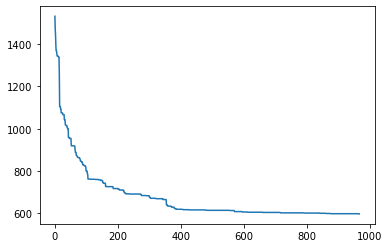

Final  cut_edges  =  597
Final max pop dev =  0.009129984543229145
Runtime =  239.563  seconds
CPU time =  239.266  seconds


Done running plans!
Runtime =  239.8566918373108  seconds


In [2]:
parameters = read_parameters('ReCom_PARAMETERS_2023.csv')
if type(parameters) == type(0):
    print('Whoops!\n\n')
    
else:
    ReComLocalSearch(parameters)